## Example use case: Solar system using the API functionality
`binary_c` can evolve orbiting objects, like in our solarsystem, during the evolution of the central star. Here we use the API interface to construct a model of the Solar system

In [1]:
import os
import re
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from binarycpython.utils.functions import temp_dir
from binarycpython import _binary_c_bindings

TMP_DIR = temp_dir("notebooks", "notebook_solar_system")
VERBOSITY = 1

First we must construct the argument string that we pass to binary_c. If you look closely you see we make use of the mass units `MMercury` etc in this argument string. `binary_c` recognizes these units, and many more! Moreover, `binary_c` formats the output for the orbiting objects automatically, so we don't have to provide a custom logging string. 

In [2]:
M_1 = 1.0  # Msun
metallicity = 0.02
max_evolution_time = 15000  # Myr. You need to include this argument.
api_log_filename_prefix = TMP_DIR,
orbiting_objects = """\
orbiting_object name=Mercury,M=1MMercury,orbital_separation=1AMercury,orbits=star1,orbital_eccentricity=0.206 \
orbiting_object name=Venus,M=1MVenus,orbital_separation=1AVenus,orbits=star1,orbital_eccentricity=0.007 \
orbiting_object name=Earth,M=1MEarth,orbital_separation=1AEarth,orbits=star1,orbital_eccentricity=0.017 \
orbiting_object name=Mars,M=1MMars,orbital_separation=1AMars,orbits=star1,orbital_eccentricity=0.093 \
orbiting_object name=Jupiter,M=1MJupiter,orbital_separation=1AJupiter,orbits=star1,orbital_eccentricity=0.048 \
orbiting_object name=Saturn,M=1MSaturn,orbital_separation=1ASaturn,orbits=star1,orbital_eccentricity=0.056 \
orbiting_object name=Uranus,M=1MUranus,orbital_separation=1AUranus,orbits=star1,orbital_eccentricity=0.047 \
orbiting_object name=Neptune,M=1MNeptune,orbital_separation=1ANeptune,orbits=star1,orbital_eccentricity=0.009 \
orbiting_object name=Pluto,M=1MPluto,orbital_separation=1APluto,orbital_eccentricity=0.2444,orbits=star1,orbital_eccentricity=0.244 \
orbiting_objects_log 1
"""
# Here we set up the argument string that is passed to the bindings

argstring = """
binary_c  M_1 {M_1} metallicity {metallicity} max_evolution_time {max_evolution_time} api_log_filename_prefix {api_log_filename_prefix} {orbiting_objects} 
""".format(
    M_1=M_1,
    metallicity=metallicity,
    max_evolution_time=max_evolution_time,
    api_log_filename_prefix=TMP_DIR,
    orbiting_objects=orbiting_objects
).strip()


output = _binary_c_bindings.run_system(argstring)
# print(output)

There is a lot of data here if you uncomment the print statement! 

Let's split it into a dict of lists of data, one list for each planet, and let's select only objects that are still orbiting their central star.

In [3]:
data = {}
for line in output.splitlines():
    match = re.search('Object (\d+) (\S+)',line)
    if match:
        number = match.group(1)
        name = match.group(2)
        if not name in data:
            data[name] = []
        x = line.split()
        if x[4] == 'CS1':
            x.pop(0) # remove first element of the list "Object" - this is superfluous
            x.pop(0) # remove second element of the list "index" - this is superfluous
            x.pop(0) # remove third element of the list "name" - this is superfluous (it's the dict key)
            x.pop(1) # remove (originally) fourth element "CS1" - this is superfluous (we select this already) 
            data[name].append(x)            

Now convert this data to Pandas dataframes

In [4]:
dataframes = {}
for planet in data:
    dataframes[planet] = pd.DataFrame(data[planet], 
                                      dtype=float, # required! argh!
                                      columns=['time',
                                               'mass',
                                               'angular momentum',
                                               'separation',
                                               'period',
                                               'eccentricity',
                                               'temperature',
                                               'angular frequency',
                                               'spin of central object',
                                               'in disc'],
                                     )
# print (dataframes['Earth']) # Uncomment to print the dataframe

We now make a plot of the separation (distance from the object to the Sun) as a function of time.

[None]

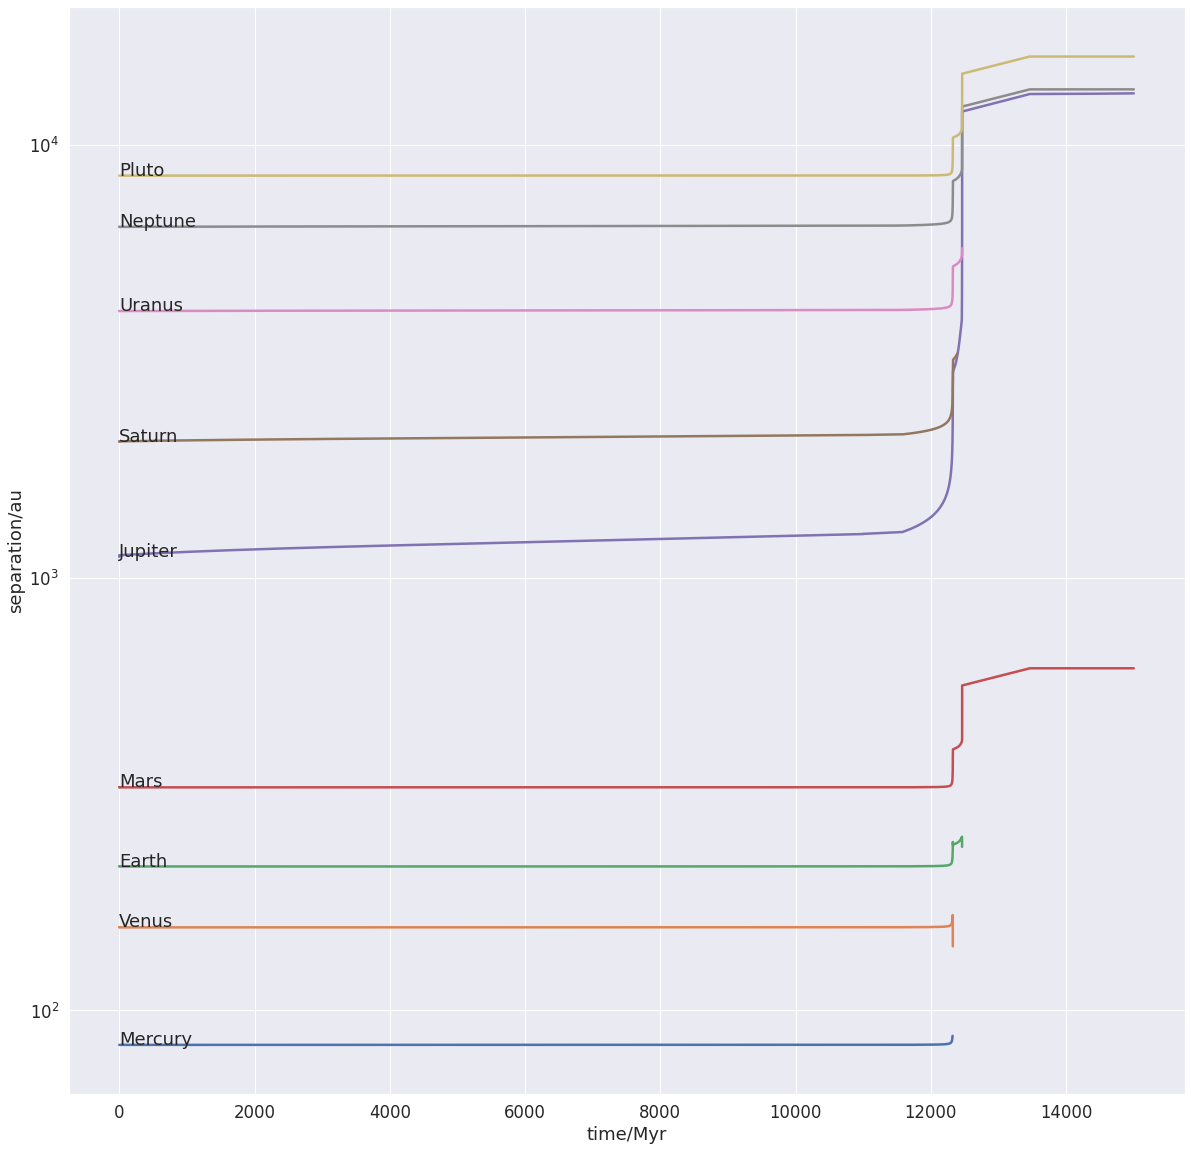

In [8]:
# set up seaborn for use in the notebook
sns.set(rc={'figure.figsize':(20,20)})
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth":2.5})

x = 'time'
y = 'separation'

for planet in dataframes:
    #print (dataframes[planet])
    df = dataframes[planet]
    p = sns.lineplot(data=df,
                     sort=False,
                     x=x,
                     y=y,
                     estimator=None,
                     ci=None,
                     legend='full'
                    )
    xx = df.head(1).loc[0,x]
    yy = df.head(1).loc[0,y]
    p.text(xx,yy,planet)
    
p.set_xlabel("time/Myr")
p.set_ylabel("separation/au")
p.set(yscale="log")

The inner objects are swallowed by the Sun when it becomes a red giant. Earth survives, although mass loss from the red-giant Sun and tides mess with its orbit somewhat. Jupiter is pushed out beyond the orbits of Saturn and Uranus, and this simple model assumes they are ejected in the interaction because Jupiter is (far) more massive. There are options to detect when its orbit is too close to Neptune, and hence possibly eject Neptune, but I'll let you explore these.

We now construct a plot of the eccentricity or temperature of each planet vs time. 

[None]

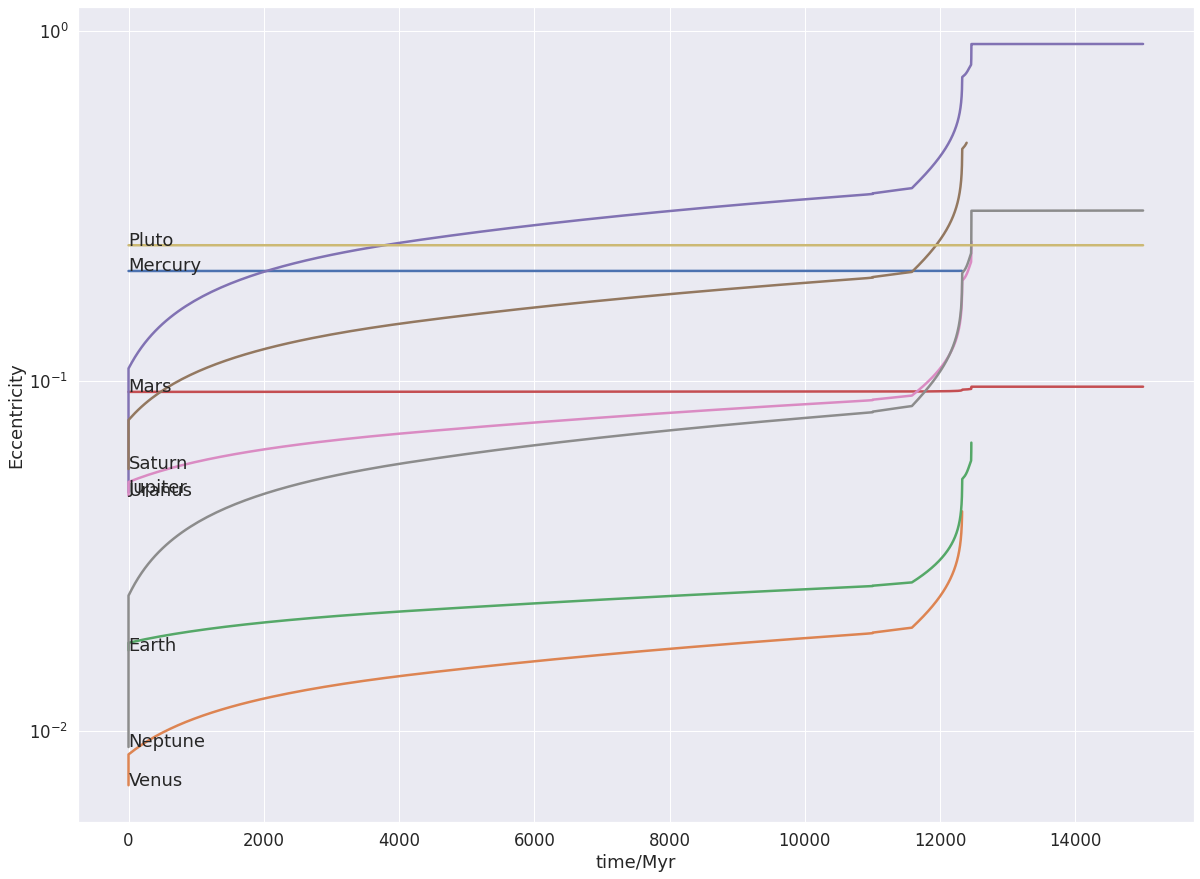

In [6]:
# Plot eccentricity
# set up seaborn for use in the notebook
sns.set(rc={'figure.figsize':(20, 15)})
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth":2.5})


#########
x = 'time'
y = 'eccentricity'
for planet in dataframes:
    df = dataframes[planet]
    p = sns.lineplot(data=df,
                     sort=False,
                     x=x,
                     y=y,
                     estimator=None,
                     ci=None,
                     legend='full'
                    )
    xx = df.head(1).loc[0,x]
    yy = df.head(1).loc[0,y]
    p.text(xx,yy,planet)
    
p.set_xlabel("time/Myr")
p.set_ylabel("Eccentricity")
p.set(yscale="log")

[None]

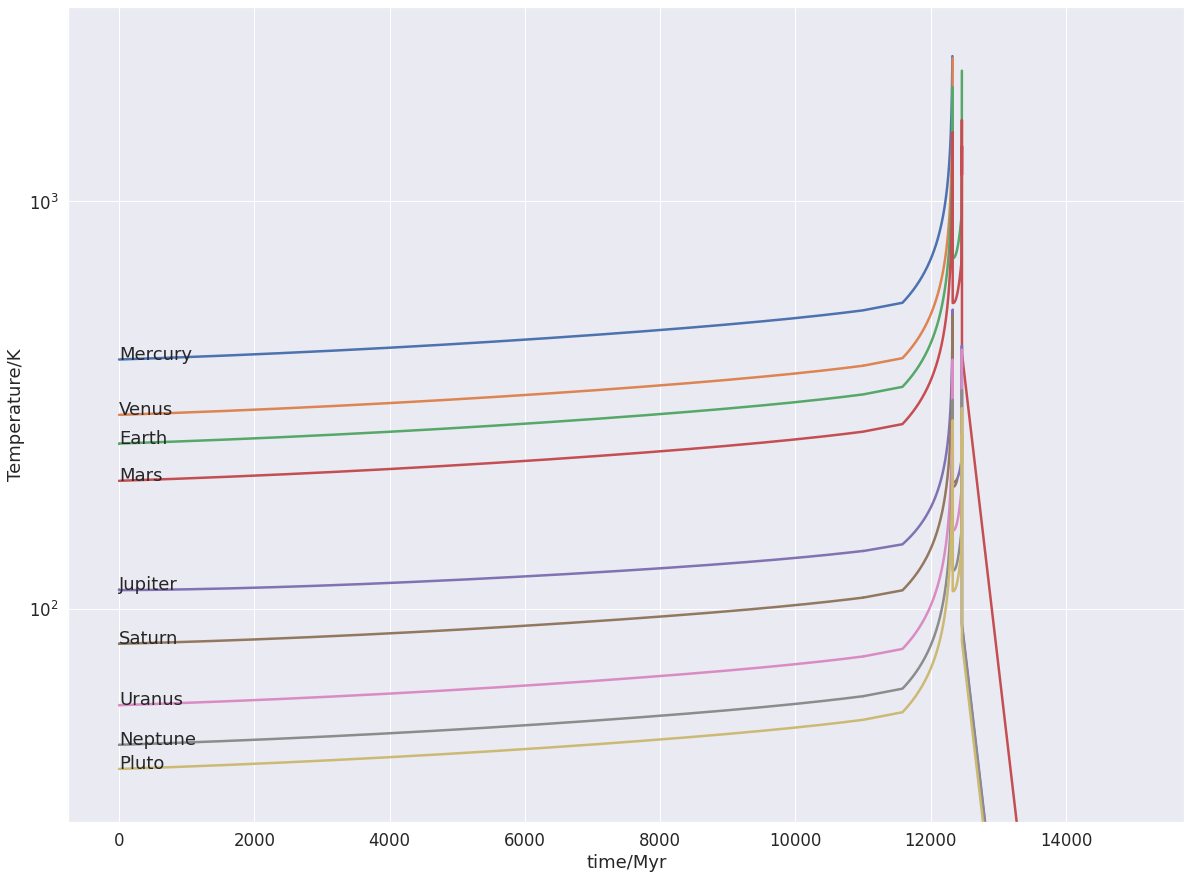

In [7]:
# Plot Temperature
# set up seaborn for use in the notebook
sns.set(rc={'figure.figsize':(20, 15)})
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth":2.5})


#########
x = 'time'
y = 'temperature'
for planet in dataframes:
    df = dataframes[planet]
    p = sns.lineplot(data=df,
                     sort=False,
                     x=x,
                     y=y,
                     estimator=None,
                     ci=None,
                     legend='full'
                    )
    xx = df.head(1).loc[0,x]
    yy = df.head(1).loc[0,y]
    p.text(xx,yy,planet)
    
p.set_xlabel("time/Myr")
p.set_ylabel("Temperature/K")
p.set(ylim=(30,3000)) # might be necessary?
p.set(yscale="log")

It gets a little toasty on Earth in the not too distant future!